In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
from collections import deque, namedtuple
%matplotlib inline
SEED = 77
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim
from utils.environment import *
from utils.utils import *
import pickle

In [2]:
class Environment(object) :
    # Creates an environmnent
    # For us, this is the behavior of the User
    def __init__(self,n_actions,  n_states, alpha, to_leave, n_recommended, n_cached,\
                rewards,SEED=77, u=None, cost = None) :
        self.SEED = SEED
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha
        # Alpha is the coefficient in which a user chooses a recommended content
        self.to_leave = to_leave
        # to_leave is the coefficient in which a user decides to quit the process
        #self.state = np.array([i for i in range(n_states)])
        self.n_recommended = n_recommended
        # n_recommend corresponds to the number of content to recommend. HERE, WE DON'T USE IT YET
        self.n_cached = n_cached
        # n_cached correponds to the number of cached content
        #self.index_recommended = create_matrix_u(self.n_states,self.n_actions,self.n_recommended)
        #self.index_cached = create_matrix_u(self.n_states,self.n_actions,self.n_cached)
        self.u = creation_u(self.n_states) if u is None else u  
        # U matrix which denotes the similarity score
        self.cost = creation_caching(self.n_states, self.n_cached) if cost is None else cost
        # It denotes the cached content (0 if cached, 1 not-cached)
        self.p0 = create_priori_popularity(self.n_states)
        # The probability to choose content j from the catalogue
        self.rewards = rewards
        # List of rewards like [RC, RnC , nRC, nRnC]
        # RC = Recommended & Cached ; nRnC = non Recommended & non Cached
        self.recommended = self.get_index_recommendation()
        
    def refresh(self,SEED = None) :
        # Reset the state to a new value
        if SEED is not None :
            self.SEED = SEED
        return random.randrange(0,self.n_states,1)
    
    def reset(self) :
        # Reset the environment to a new random state. 
        #It resets both the recommendation and the cached indexes
        # It returns a first state
        self.u = creation_u(self.n_states)
        self.cached = creation_caching(self.n_states, self.n_cached)
        self.p0 = create_priori_popularity(self.n_states)
    
        return self.state[random.randrange(0,self.n_states,1)]

    
    
    def find_reward(self, action,state) :
        # Finds the reward for the given action starting in the given state 
        # It tests whether the state is recommended, cached or not
        
        # It gives from the u matrix whether the action from the state is recommended or not
        if ((state is None) or (action is None) ):
            return None
        
        recommended_matrix = self.recommended[state]
        is_cached = get_cached(action, self.cost)
        
        if ( (action in recommended_matrix) and (is_cached)) :
            # Content recommended and cached : best reward
            return self.rewards[0]
        elif ( (action in recommended_matrix) and ( not is_cached) ) :
            # Content recommended but not cached
            return self.rewards[1]
        elif ( (action not in recommended_matrix ) and (is_cached)) :
            # Content not recommended but cached
            return self.rewards[2]
        else :
            # Content neither recommended nor cached
            return self.rewards[3]
    
    
    def step(self, action,state) :
        # Returns the state, reward after taking the action in input
        # done is a boolean to say whether the user quits the game or not
        # We want to return the state where will be the user when we suggest him "action"
        # Knowing he is in the current 'state'
        
        if (random.uniform(0, 1) < self.to_leave) :
            # The user stops to play
            reward = self.find_reward(action,state)
            new_state,reward, done = None,reward,True
            return new_state,reward, done
        else :
            
            # Else the user will choose among the contents
            if (random.uniform(0,1)< self.alpha ) :
                
                # Then the user chooses a content among the recommended contentss
                new_state = action
                reward = self.find_reward(action,state)
            else :
                # The user picks a content randomly in the catalogue
                
                new_state = get_random_state(self.p0) 
                reward = self.find_reward(action,state)
                
                
            done = False
            
        if (action == state ) : 
            return self.step(action, state)
        else : 
            return new_state, reward, done
    
    def get_index_recommendation(self) :
        # Returns a matrix with all index of recommended content
        recommended = []
        for state in range(self.n_actions) :
            recommended.append(get_recommended(state,self.n_recommended,self.u))
        return recommended
    
    def get_index_cached(self) :
        
        return self.cost
    
    
    

In [3]:
def q_learning_max(env,alpha,gamma,epsilon,max_iter,v1=True, threshold = 0.1) :

    # Alpha : learning rate
    # Gamma : Long-term reward
    # Epsilon-greedy : do we exploit or explore
    """Training the agent"""
    # Initialisation of the q_table
    q_table = np.zeros([env.n_states, env.n_actions])
    
    # For plotting metrics
    q_table_diff = []
    max_diff = threshold + 1
    i=0
    
    all_reward = []
    all_diff = []
    
    
    
    before_time = time.time()
    while( (i < max_iter) and (max_diff > threshold)) :
        # We copy the first step of the table to compare at the end
        before_q = copy.copy(q_table)

        # Initialize the state
        state = env.refresh()
        # Initialization of the variables
        # Penalties aims to show how will evolve the average reward through the process
        epochs= 0
        current_reward = 0
        # The boolean which says whether the process is done or not
        done = False
        
        while not done :

            if  (random.uniform(0, 1) < epsilon)  :
                # Explore action space
                if v1 :
                    action = random.randint(0,env.n_actions-1)
                else :
                    recommended_contents =  env.recommended[state]
                    index_state = random.randrange(0,len(recommended_contents),1)
                    action = recommended_contents[index_state]           
            else :
                # Exploit learned values
                action = np.argmax(q_table[state])
               
            # Go to the next state
            next_state, reward, done = env.step(action,state)

            if ( (next_state is None)   ) :
                # We stop when the user leaves the process
                break

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            # Q learning algorithm

            new_value = (1- alpha)* old_value + alpha * (reward + gamma * next_max)
            q_table[state,action] = new_value
            # Just compute the penalty by hand to see how well is our decision

            # Go to the next state
            state = next_state
            epochs +=1
            current_reward += reward
                
        q_table_diff.append((q_table - before_q).max()  )
        i+=1
        all_reward.append(current_reward)
        if (i%100 == 0) : 
            max_diff = np.mean(q_table_diff)
            all_diff.append(max_diff)
            q_table_diff = []
            
        
    
    time_train =  time.time() - before_time
    return (1-gamma)* q_table, all_diff, all_reward


In [4]:
param_env = { 'n_actions' : 50,\
             'n_states' : 50, \
             'alpha' : 0.6, \
             'to_leave' : 0.1, \
             'n_recommended' : 10,\
             'n_cached' : 5,\
             'rewards' : [2,1,1,0],\
             'SEED' : 77  }

In [5]:
env = Environment(**param_env)

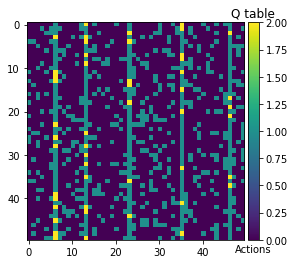

In [8]:
plot_q_table(get_matrix_rewards(env))

In [4]:
with open('env.pickle', 'rb') as f:
    env = pickle.load(f)


In [38]:

# with open('./checkpoints/env.pickle', 'wb') as f:
#     pickle.dump(env, f)



In [5]:
q_table_q , all_diff, all_reward_q = q_learning_max(env,alpha = 0.6,gamma = 0.9 ,epsilon = 0.1 ,\
                                                    max_iter = 50000,v1=True, threshold = 1e-5)

In [6]:
q_table_q1 , all_diff1, all_reward_q1 = q_learning_max(env,alpha = 0.6,gamma = 0.99 ,epsilon = 0.1 ,\
                                                    max_iter = 50000,v1=False, threshold = 1e-5)

In [7]:
with open('./checkpoints/q_tables_q_learning_09.pickle', 'wb') as f:
    pickle.dump([q_table_q,q_table_q1], f)

In [8]:
with open('./checkpoints/q_learning_rewards_09.pickle', 'wb') as f:
    pickle.dump([all_reward_q,all_reward_q1], f)

In [27]:
for i in range(len(q_table_q)) : 
    q_table_q[i][i] = np.mean(q_table_q)

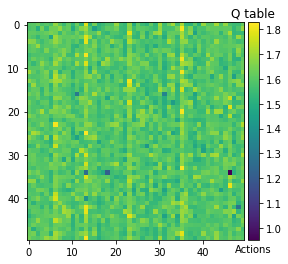

In [28]:
plot_q_table(q_table_q)

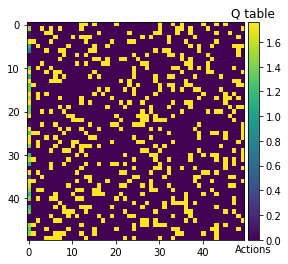

In [29]:
plot_q_table(q_table_q1)

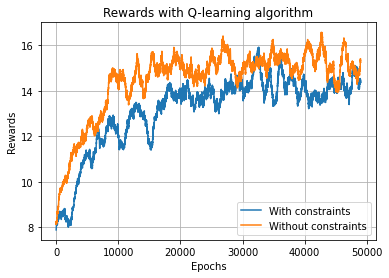

In [9]:
plt.plot( running_mean(all_reward_q,1000), label ='With constraints' )
plt.plot( running_mean(all_reward_q1,1000) , label ='Without constraints')
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.title('Rewards with Q-learning algorithm')
plt.legend()
plt.grid(True)
plt.show()


In [15]:
q_table_q , all_diff, all_reward_q = q_learning_max(env,alpha = 0.6,gamma = 0 ,epsilon = 0.1 ,\
                                                    max_iter = 50000,v1=True, threshold = 1e-10)

In [23]:
q_table_q1 , all_diff1, all_reward_q1 = q_learning_max(env,alpha = 0.6,gamma = 0 ,epsilon = 0.1 ,\
                                                    max_iter = 50000,v1=False, threshold = 1e-20)

In [27]:
with open('./checkpoints/q_tables_q_learning_0.pickle', 'wb') as f:
    pickle.dump([q_table_q,q_table_q1], f)

In [28]:
with open('./checkpoints/q_learning_rewards_0.pickle', 'wb') as f:
    pickle.dump([all_reward_q,all_reward_q1], f)

In [19]:
for i in range(len(q_table_q)) : 
    q_table_q[i][i] = np.mean(q_table_q)

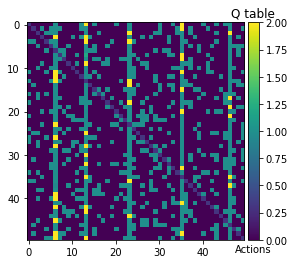

In [20]:
plot_q_table(q_table_q)

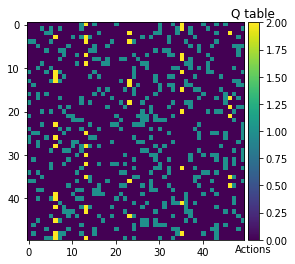

In [26]:
plot_q_table(q_table_q1)

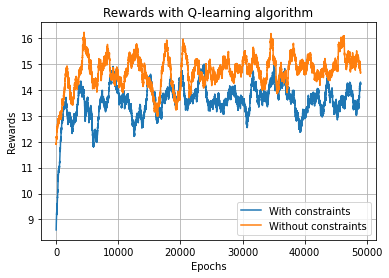

In [25]:
plt.plot( running_mean(all_reward_q,1000), label ='With constraints' )
plt.plot( running_mean(all_reward_q1,1000) , label ='Without constraints')
plt.xlabel('Epochs')
plt.ylabel('Rewards')
plt.title('Rewards with Q-learning algorithm')
plt.legend()
plt.grid(True)
plt.show()
